In [1]:
!pip install pandas scikit-learn tensorflow transformers matplotlib timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 62.7 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-4-61afceb4d4e3>:76: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-4-61afceb4d4e3>:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast(

Epoch [1/20], Loss: 0.6065, Train Accuracy: 0.7428, Val Loss: 0.5046, Val Accuracy: 0.7404


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d73f472f370>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d73f472f370>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch [2/20], Loss: 0.5572, Train Accuracy: 0.7428, Val Loss: 0.4801, Val Accuracy: 0.7308
Epoch [3/20], Loss: 0.5409, Train Accuracy: 0.7428, Val Loss: 0.5137, Val Accuracy: 0.7308
Epoch [4/20], Loss: 0.5235, Train Accuracy: 0.7332, Val Loss: 0.5117, Val Accuracy: 0.7308
Epoch [5/20], Loss: 0.5835, Train Accuracy: 0.7428, Val Loss: 0.5354, Val Accuracy: 0.7404
Epoch [6/20], Loss: 0.5714, Train Accuracy: 0.7452, Val Loss: 0.5054, Val Accuracy: 0.7308
Epoch [7/20], Loss: 0.5405, Train Accuracy: 0.7668, Val Loss: 0.4869, Val Accuracy: 0.7500
Epoch [8/20], Loss: 0.5181, Train Accuracy: 0.7500, Val Loss: 0.4897, Val Accuracy: 0.7500
Epoch [9/20], Loss: 0.5231, Train Accuracy: 0.7548, Val Loss: 0.4664, Val Accuracy: 0.7500
Epoch [10/20], Loss: 0.4917, Train Accuracy: 0.7716, Val Loss: 0.4826, Val Accuracy: 0.7115
Epoch [11/20], Loss: 0.4643, Train Accuracy: 0.7500, Val Loss: 0.4637, Val Accuracy: 0.7115
Epoch [12/20], Loss: 0.4765, Train Accuracy: 0.7644, Val Loss: 0.4579, Val Accuracy: 0.7

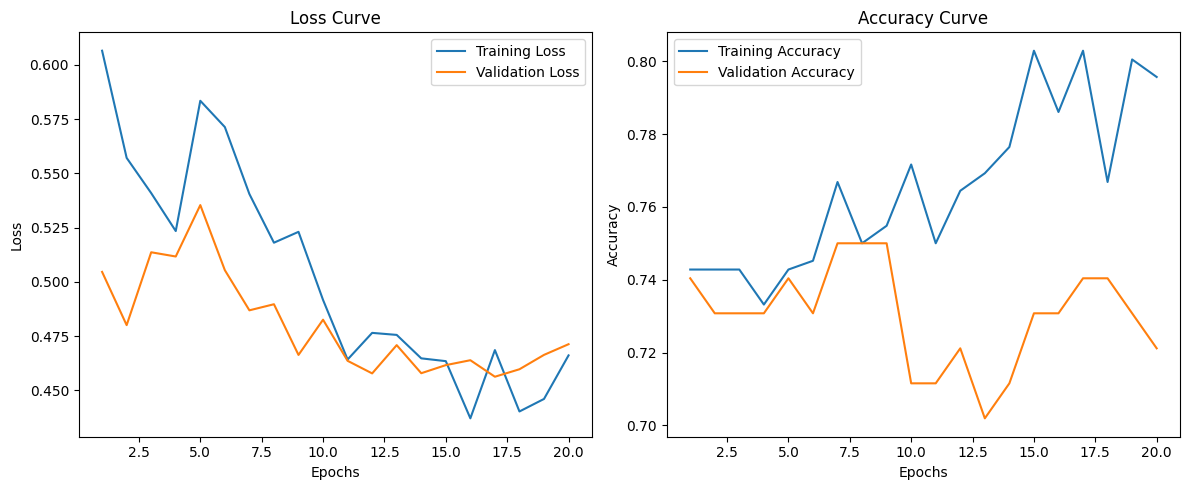

<ipython-input-4-61afceb4d4e3>:242: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  deit_model.load_state_dict(torch.load('best_model.pth'))


              precision    recall  f1-score   support

         0.0       0.81      0.91      0.85        96
         1.0       0.59      0.38      0.46        34

    accuracy                           0.77       130
   macro avg       0.70      0.64      0.66       130
weighted avg       0.75      0.77      0.75       130

[[87  9]
 [21 13]]


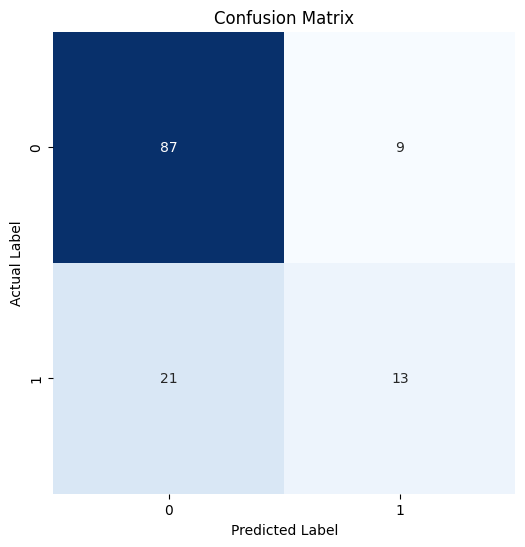

In [4]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.transforms import AutoAugment, AutoAugmentPolicy

# Custom Dataset for loading images and labels
class GlaucomaDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, torch.tensor(label, dtype=torch.float32)

# Function to load data
def load_data(dataset_dir, csv_file):
    df = pd.read_csv(csv_file)
    image_paths = [os.path.join(dataset_dir, filename) for filename in df['Filename']]
    labels = df['Glaucoma'].values
    return image_paths, labels

# Function to calculate accuracy
def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = model(inputs)
            preds = torch.sigmoid(outputs) > 0.5
            total += labels.size(0)
            correct += (preds.squeeze().cpu() == labels.cpu()).sum().item()
    return correct / total

# Function to validate model
def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            val_loss += loss.item()
    return val_loss / len(val_loader)

# Modified training loop with early stopping, gradient clipping, and mixed precision
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_loss = float('inf')
    patience_counter = 0
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels.unsqueeze(1))

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

        # Calculate training and validation metrics
        train_accuracy = calculate_accuracy(train_loader, model)
        val_loss = validate(model, val_loader, criterion)
        val_accuracy = calculate_accuracy(val_loader, model)

        # Scheduler step
        scheduler.step(val_loss)

        # Append metrics for plotting
        train_losses.append(running_loss / len(train_loader))
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, "
              f"Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    return train_losses, val_losses, train_accuracies, val_accuracies

# Function to plot the loss and accuracy curves
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Function to evaluate the model
def evaluate(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = model(inputs)
            preds = torch.sigmoid(outputs) > 0.5
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    return classification_report(all_labels, all_preds), confusion_matrix(all_labels, all_preds)

# Function to plot the confusion matrix
def plot_confusion_matrix(cm):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, square=True)
    plt.title("Confusion Matrix")
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Load the dataset and preprocess
dataset_dir = '/content/drive/My Drive/Images/'
csv_file = '/content/drive/My Drive/glaucoma.csv'
image_paths, labels = load_data(dataset_dir, csv_file)

# Split into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=42, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Define the transform (with expanded data augmentation)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    AutoAugment(policy=AutoAugmentPolicy.IMAGENET),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create Datasets and DataLoaders
train_dataset = GlaucomaDataset(X_train, y_train, transform=train_transform)
val_dataset = GlaucomaDataset(X_val, y_val, transform=val_test_transform)
test_dataset = GlaucomaDataset(X_test, y_test, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=4, pin_memory=True)

# Create the DEIT model (with dropout and regularization)
class GlaucomaNet(nn.Module):
    def __init__(self, model):
        super(GlaucomaNet, self).__init__()
        self.model = model
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(1000, 1)

    def forward(self, x):
        x = self.model(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Load pre-trained DEIT model
deit_model = timm.create_model('deit_base_patch16_224', pretrained=True, num_classes=1000)
deit_model = GlaucomaNet(deit_model)

# Set up loss, optimizer, scheduler
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(deit_model.parameters(), lr=1e-4, weight_decay=1e-2)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Training the model with early stopping
deit_model = deit_model.to('cuda')
train_losses, val_losses, train_accuracies, val_accuracies = train(deit_model, train_loader, val_loader, criterion, optimizer, scheduler,num_epochs=20)

# Plot loss and accuracy curves
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

# Load the best model
deit_model.load_state_dict(torch.load('best_model.pth'))

# Evaluating on test data
report, cm = evaluate(deit_model, test_loader)
print(report)
print(cm)

# Plot confusion matrix
plot_confusion_matrix(cm)

Epoch [1/20], Loss: 0.7593, Train Accuracy: 0.6729, Val Loss: 0.6722, Val Accuracy: 0.6827
Epoch [2/20], Loss: 0.6791, Train Accuracy: 0.6682, Val Loss: 0.5924, Val Accuracy: 0.7308
Epoch [3/20], Loss: 0.6357, Train Accuracy: 0.7477, Val Loss: 0.6317, Val Accuracy: 0.6538
Epoch [4/20], Loss: 0.6702, Train Accuracy: 0.5748, Val Loss: 0.5862, Val Accuracy: 0.6923
Epoch [5/20], Loss: 0.6424, Train Accuracy: 0.7056, Val Loss: 0.6905, Val Accuracy: 0.5673
Epoch [6/20], Loss: 0.6744, Train Accuracy: 0.7617, Val Loss: 0.6485, Val Accuracy: 0.6538
Epoch [7/20], Loss: 0.5854, Train Accuracy: 0.7570, Val Loss: 0.5904, Val Accuracy: 0.6731
Epoch [8/20], Loss: 0.5224, Train Accuracy: 0.7710, Val Loss: 0.6296, Val Accuracy: 0.6635
Epoch [9/20], Loss: 0.4725, Train Accuracy: 0.7991, Val Loss: 0.7045, Val Accuracy: 0.5865
Epoch [10/20], Loss: 0.4757, Train Accuracy: 0.8271, Val Loss: 0.6056, Val Accuracy: 0.6923
Epoch [11/20], Loss: 0.4085, Train Accuracy: 0.8084, Val Loss: 0.5494, Val Accuracy: 0.66

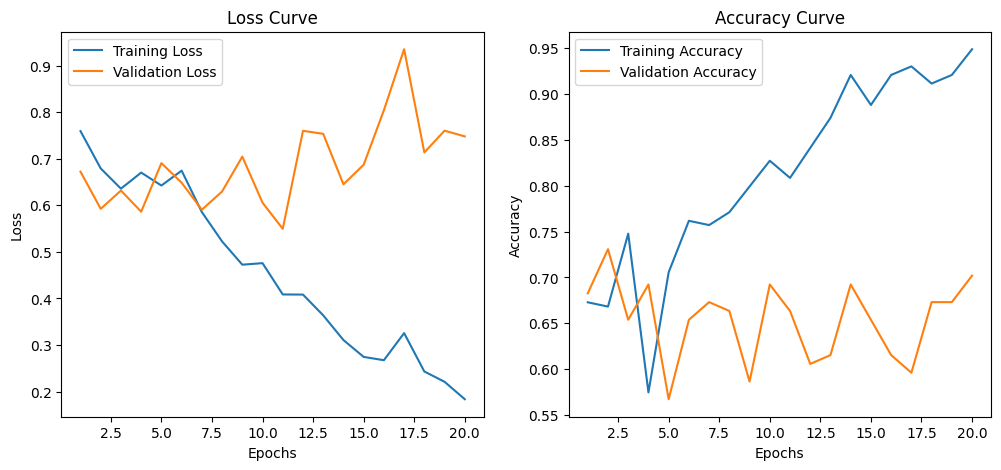

              precision    recall  f1-score   support

         0.0       0.86      0.72      0.78        96
         1.0       0.46      0.68      0.55        34

    accuracy                           0.71       130
   macro avg       0.66      0.70      0.67       130
weighted avg       0.76      0.71      0.72       130

[[69 27]
 [11 23]]


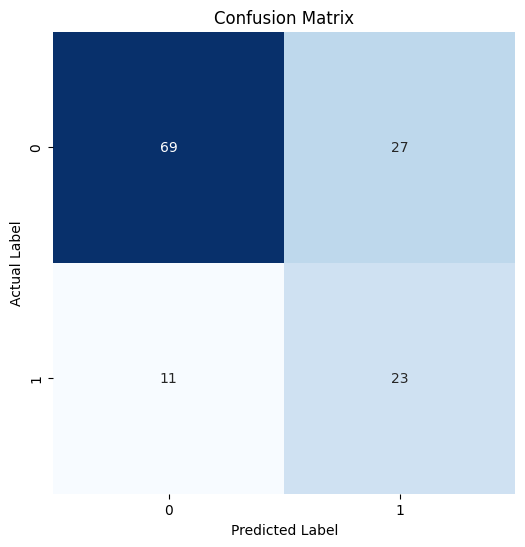

In [6]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Custom Dataset for loading images and labels
class GlaucomaDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB").resize((224, 224))
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, torch.tensor(label, dtype=torch.float32)

# Function to load data
def load_data(dataset_dir, csv_file):
    df = pd.read_csv(csv_file)
    image_paths = [os.path.join(dataset_dir, filename) for filename in df['Filename']]
    labels = df['Glaucoma'].values
    return image_paths, labels

# Function to create a balanced dataset with 50% glaucoma-positive and 50% glaucoma-negative images
def balance_data(image_paths, labels):
    labels = np.array(labels)

    # Separate positive and negative cases
    positive_indices = np.where(labels == 1)[0]
    negative_indices = np.where(labels == 0)[0]

    # Get the number of samples to use from each class (based on the minority class)
    num_samples = min(len(positive_indices), len(negative_indices))

    # Randomly sample from both classes to get an equal number of positive and negative samples
    balanced_positive_indices = np.random.choice(positive_indices, num_samples, replace=False)
    balanced_negative_indices = np.random.choice(negative_indices, num_samples, replace=False)

    # Combine the indices and shuffle
    balanced_indices = np.concatenate([balanced_positive_indices, balanced_negative_indices])
    np.random.shuffle(balanced_indices)

    # Return balanced image paths and labels
    balanced_image_paths = [image_paths[i] for i in balanced_indices]
    balanced_labels = labels[balanced_indices]

    return balanced_image_paths, balanced_labels

# Function to calculate accuracy
def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = model(inputs)
            preds = torch.sigmoid(outputs) > 0.5
            total += labels.size(0)
            correct += (preds.squeeze().cpu() == labels.cpu()).sum().item()
    return correct / total

# Function to validate model
def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            val_loss += loss.item()
    return val_loss / len(val_loader)

# Training loop with scheduler
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Calculate training and validation metrics
        train_accuracy = calculate_accuracy(train_loader, model)
        val_loss = validate(model, val_loader, criterion)
        val_accuracy = calculate_accuracy(val_loader, model)

        # Scheduler step
        scheduler.step(val_loss)

        # Append metrics for plotting
        train_losses.append(running_loss / len(train_loader))
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, "
              f"Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Function to plot the loss and accuracy curves
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Plot loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.show()

# Function to evaluate the model
def evaluate(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = model(inputs)
            preds = torch.sigmoid(outputs) > 0.5
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    return classification_report(all_labels, all_preds), confusion_matrix(all_labels, all_preds)

# Function to plot the confusion matrix
def plot_confusion_matrix(cm):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, square=True)
    plt.title("Confusion Matrix")
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Load the dataset and preprocess
dataset_dir = '/content/drive/My Drive/Images/'
csv_file = '/content/drive/My Drive/glaucoma.csv'
image_paths, labels = load_data(dataset_dir, csv_file)

# Split into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=42, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Balance the training set to have 50% glaucoma-positive and 50% glaucoma-negative
balanced_train_paths, balanced_train_labels = balance_data(X_train, y_train)

# Define the transform (with data augmentation)
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create Datasets and DataLoaders
balanced_train_dataset = GlaucomaDataset(balanced_train_paths, balanced_train_labels, transform=transform)
val_dataset = GlaucomaDataset(X_val, y_val, transform=transform)
test_dataset = GlaucomaDataset(X_test, y_test, transform=transform)

balanced_train_loader = DataLoader(balanced_train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# Create the DEIT model (smaller architecture, optional)
deit_model = timm.create_model('deit_tiny_patch16_224', pretrained=True, num_classes=1)

# Set up loss, optimizer, scheduler
criterion = nn.BCEWithLogitsLoss()  # For binary classification
optimizer = optim.Adam(deit_model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

# Training the model and getting metrics
deit_model = deit_model.to('cuda')
train_losses, val_losses, train_accuracies, val_accuracies = train(deit_model, balanced_train_loader, val_loader, criterion, optimizer, scheduler)

# Plot loss and accuracy curves
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

# Evaluating on test data
report, cm = evaluate(deit_model, test_loader)
print(report)
print(cm)

# Plot confusion matrix
plot_confusion_matrix(cm)
